In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import datetime
import threading
import os
import time
import pickle
from concurrent.futures import ThreadPoolExecutor
import pprint

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from SPOT.spot import dSPOT
import tigramite.data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
import pandas as pd
from pingouin import partial_corr

from util_funcs.loaddata import load
# from utils.draw_graph import draw_weighted_graph
from util_funcs.evaluation_function import prCal, my_acc, pr_stat, print_prk_acc
from util_funcs.format_ouput import format_to_excel
from util_funcs.excel_utils import saveToExcel, readExl

C:\Users\pyc\Anaconda3\envs\statsenv\lib\site-packages\outdated\utils.py:18: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Select which dataset to use

In [2]:
# Data params
data_source="real_micro_service"
# Root trace params
testrun_round=1
frontend=[14]
true_root_cause=[6, 28, 30, 31]
n_init = 1000

# Data params
# data_source="pymicro"
# # Root trace params
# testrun_round=1
# frontend=[16]
# true_root_cause=[1]
# n_init = 500

# Debug params
plot_figures=False
verbose=False
kws = {}

In [3]:
print("{:#^80}".format("MicroCause"))
dir_output = "microcause/results/" + data_source
os.makedirs(dir_output, exist_ok=True)
if verbose:
    print("{:-^80}".format("Data load phase"))
# region Load and preprocess data
data, data_head = load(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=False,
    zero_fill_method='prevlatter',
    aggre_delta=1,
    verbose=True,
)

###################################MicroCause###################################
          Zero fill method              : Previous then latter
          Data header                   :
              1( 304 0s):ace-events-production-20160819-142035.ng.bluemix.net/socket.io/;GET
              2(2866 0s):api.xforce.ibmcloud.com/taxii;POST
              3(6743 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/apps/api/model;GET
              4(4970 0s):ace-dashboard-test-20160819-141650.ng.bluemix.net/dashboard/api/cf-apps-info;GET
              5( 574 0s):api.xforce.ibmcloud.com/socket.io/;GET
              6(5419 0s):ace-events-test-20160819-141650.ng.bluemix.net/events/cfServices;GET
              7(   0 0s):api.ng.bluemix.net/v2/app;PUT
              8(1064 0s):api.xforce.ibmcloud.com/casefiles/shared;GET
              9(4253 0s):ace-abstraction-test-20160819-141650.ng.bluemix.net/model/v1/dashboard;GET
             10(5799 0s):ace-appdetails-test-20160819-141650.ng.bluemix.net/s

In [4]:
# svc_id = 13
def run_SPOT(data, q=1e-3, d=300, n_init=None):
    result_dict = {}
    if n_init is None:
        n_init = int(0.5 * len(data))
    for svc_id in range(len(data_head)):
        print("{:-^40}".format("svc_id: {}".format(svc_id)))
        init_data = data[:n_init, svc_id] 	# initial batch
        _data = data[n_init:, svc_id]  		# stream
        # q: risk parameter
        # d: depth parameter
        s = dSPOT(q,d)     	# DSPOT object
        s.fit(init_data,_data) 	# data import
        s.initialize() 	  		# initialization step
        results = s.run()    	# run
    #     s.plot(results) 	 	# plot
        result_dict[svc_id] = results
    return result_dict

In [5]:
def get_eta(SPOT_res, n_init):
    eta = np.zeros([len(data_head)])
    ab_timepoint = [0 for i in range(len(data_head))]
    for svc_id in range(len(data_head)):
        mask = data[n_init:, svc_id] > np.array(SPOT_res[svc_id]['thresholds'])
        ratio = np.abs(data[n_init:, svc_id] - np.array(SPOT_res[svc_id]['thresholds'])) / np.array(SPOT_res[svc_id]['thresholds'])
        if mask.nonzero()[0].shape[0] > 0:
            eta[svc_id] = np.max(ratio[mask.nonzero()[0]])
            ab_timepoint[svc_id] = np.min(mask.nonzero()[0])
        else:
            eta[svc_id] = 0
    return eta, ab_timepoint

In [6]:
def run_pcmci(pc_alpha = 0.1, verbosity=0):
    dataframe = pp.DataFrame(data)
    cond_ind_test = ParCorr()
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=verbosity)
    pcmci_res = pcmci.run_pcmci(tau_max=10, pc_alpha=pc_alpha)
    # pcmci.print_significant_links(p_matrix=results['p_matrix'],
    #                                      val_matrix=results['val_matrix'],
    #                                      alpha_level=0.1)
    return pcmci, pcmci_res

def get_links(pcmci, results, alpha_level = 0.01):
    pcmci_links = pcmci.return_significant_links(results['p_matrix'], results['val_matrix'], alpha_level=alpha_level, include_lagzero_links=False)
    g = nx.DiGraph()
    for i in range(len(data_head)):
        g.add_node(i)
    for n, links in pcmci_links['link_dict'].items():
        for l in links:
            g.add_edge(n, l[0])
    return g

In [7]:
def get_Q_matrix(g, rho=0.2):
    corr = np.corrcoef(np.array(data).T)
    for i in range(corr.shape[0]):
        corr[i, i] = 0.0
    corr = np.abs(corr)
    
    Q = np.zeros([len(data_head), len(data_head)])
    for e in g.edges():
        Q[e[0], e[1]] = corr[frontend[0]-1, e[1]]
        backward_e = (e[1], e[0])
        if backward_e not in g.edges():
            Q[e[1], e[0]] = rho * corr[frontend[0]-1, e[0]]
            
    adj = nx.adj_matrix(g).todense()
    for i in range(len(data_head)):
        P_pc_max = None
        res_l = np.array([corr[frontend[0]-1, k] for k in adj[:, i]])
        if corr[frontend[0]-1, i] > np.max(res_l):
            Q[i, i] = corr[frontend[0]-1, i] - np.max(res_l)
        else:
            Q[i, i] = 0
    l = []
    for i in np.sum(Q, axis=1):
        if i > 0:
            l.append(1.0/i)
        else:
            l.append(0.0)
    l = np.diag(l)
    Q = np.dot(l, Q)
    return Q

In [8]:
def get_Q_matrix_part_corr(g, rho=0.2):
    df = pd.DataFrame(data, columns=data_head)
    def get_part_corr(x, y):
        cond = get_confounders(y)
        if x in cond:
            cond.remove(x)
        if y in cond:
            cond.remove(y)
        ret = partial_corr(data=df, 
                           x=df.columns[x], y=df.columns[y], covar=[df.columns[_] for _ in cond], 
                           method='pearson')
        # For a valid transition probability, use absolute correlation values.
        return abs(float(ret.r))
    
    # Calculate the parent nodes set.
    pa_set = {}
    for e in g.edges():
        # Skip self links.
        if e[0] == e[1]:
            continue
        if e[1] not in pa_set:
            pa_set[e[1]] = set([e[0]])
        else:
            pa_set[e[1]].add(e[0])
    # Set an empty set for the nodes without parent nodes.
    for n in g.nodes():
        if n not in pa_set:
            pa_set[n] = set([])
            
    def get_confounders(j: int):
        ret = pa_set[frontend[0]-1].difference([j])
        ret = ret.union(pa_set[j])
        return ret
    
    Q = np.zeros([len(data_head), len(data_head)])
    for e in g.edges():
        # Do not add self links.
        if e[0] == e[1]:
            continue
        # e[0] --> e[1]: cause --> result
        # Forward step. 
        # Note for partial correlation, the two variables cannot be the same.
        if frontend[0]-1 != e[0]:
            Q[e[1], e[0]] = get_part_corr(frontend[0]-1, e[0])
        # Backward step
        backward_e = (e[1], e[0])
        # Note for partial correlation, the two variables cannot be the same.
        if backward_e not in g.edges() and frontend[0]-1 != e[1]:
            Q[e[0], e[1]] = rho * get_part_corr(frontend[0]-1, e[1])

    adj = nx.adj_matrix(g).todense()
    for i in range(len(data_head)):
        # Calculate P_pc^max
        P_pc_max = []
        # (k, i) in edges.
        for k in adj[:, i].nonzero()[0]:
            # Note for partial correlation, the two variables cannot be the same.
            if frontend[0]-1 != k:
                P_pc_max.append(get_part_corr(frontend[0]-1, k))
        if len(P_pc_max) > 0:
            P_pc_max = np.max(P_pc_max)
        else:
            P_pc_max = 0

        # Note for partial correlation, the two variables cannot be the same.
        if frontend[0]-1 != i:
            q_ii = get_part_corr(frontend[0]-1, i)
            if q_ii > P_pc_max:
                Q[i, i] = q_ii - P_pc_max
            else:
                Q[i, i] = 0

    l = []
    for i in np.sum(Q, axis=1):
        if i > 0:
            l.append(1.0/i)
        else:
            l.append(0.0)
    l = np.diag(l)
    Q = np.dot(l, Q)
    return Q

In [9]:
def randomwalk(
    P,
    epochs,
    start_node,
    teleportation_prob,
    walk_step=50,
    print_trace=False,
):
    n = P.shape[0]
    score = np.zeros([n])
    current = start_node - 1
    for epoch in range(epochs):
        current = start_node - 1
        if print_trace:
            print("\n{:2d}".format(current + 1), end="->")
        for step in range(walk_step):
            if np.sum(P[current]) == 0:
                break
            else:
                next_node = np.random.choice(range(n), p=P[current])
                if print_trace:
                    print("{:2d}".format(current + 1), end="->")
                score[next_node] += 1
                current = next_node
    label = [i for i in range(n)]
    score_list = list(zip(label, score))
    score_list.sort(key=lambda x: x[1], reverse=True)
    return score_list

In [10]:
def get_gamma(score_list, eta, lambda_param=0.8):
    gamma = [0 for _ in range(len(data_head))]
    max_vis_time = np.max([i[1] for i in score_list])
#     max_vis_time = 1.0
    max_eta = np.max(eta)
    for n,vis in score_list:
        gamma[n] = lambda_param * vis / max_vis_time + (1-lambda_param) * eta[n] / max_eta
    return gamma

In [11]:
def evaluate(gamma):
    score_list = sorted(zip([(i+1) for i in range(len(data_head))], gamma), key=lambda x:x[1], reverse=True)
    acc = my_acc(score_list, true_root_cause, n=len(data_head))
    prks = pr_stat(score_list, true_root_cause, k=5)
    print_prk_acc(prks, acc)
    return prks, acc

In [12]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000})

In [13]:
SPOT_res = run_SPOT(data, q=1e-3, d=300)
eta, ab_timepoint = get_eta(SPOT_res, int(0.5 * len(data)))

 34%|#########################1                                                 | 1209/3600 [00:00<00:00, 11970.12it/s]

---------------svc_id: 0----------------
Initial threshold : 2618.9459062394144
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4973.869745501174
	L = 618.2769734016148
Extreme quantile (probability = 0.001): 17444.89707124048


 45%|#################################5                                         | 1612/3600 [00:00<00:00, 15881.51it/s]

---------------svc_id: 1----------------
Initial threshold : 0.5188945346934047
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 33.910513345627784
	L = 294.04213114225354
Extreme quantile (probability = 0.001): 101.59826342993497


 27%|####################5                                                        | 962/3600 [00:00<00:00, 8513.10it/s]

---------------svc_id: 2----------------
Initial threshold : 2.3090542366699958
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 22.786521874568205
	L = 268.2009989953141
Extreme quantile (probability = 0.001): 70.23038668373357


  0%|                                                                                         | 0/3600 [00:00<?, ?it/s]

---------------svc_id: 3----------------
Initial threshold : 110.69418997068864
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4.273398922060068
	L = 159.4066182203703
Extreme quantile (probability = 0.001): 123.43220020594597


 18%|##############                                                               | 658/3600 [00:00<00:00, 6236.97it/s]

---------------svc_id: 4----------------
Initial threshold : 211.11953455265956
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 472.86070129635016
	L = 465.32205490469505
Extreme quantile (probability = 0.001): 1620.6075235794904


100%|###########################################################################| 3600/3600 [00:00<00:00, 21621.49it/s]


---------------svc_id: 5----------------
Initial threshold : 1.759141976687777
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 0.8367743221638937
	L = 53.416943326961444
Extreme quantile (probability = 0.001): 4.253371997035588
---------------svc_id: 6----------------


 13%|##########                                                                   | 469/3600 [00:00<00:00, 4383.05it/s]

Initial threshold : 0.31946158598848146
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1.01627718004201
	L = 66.04949825181649
Extreme quantile (probability = 0.001): 3.3487479590456104


 38%|############################9                                               | 1373/3600 [00:00<00:00, 6878.30it/s]

---------------svc_id: 7----------------
Initial threshold : 0.15072519381149996
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 28.803823544835893
	L = 283.43302911971307
Extreme quantile (probability = 0.001): 86.00823716973383


 27%|####################6                                                        | 967/3600 [00:00<00:00, 8995.46it/s]

---------------svc_id: 8----------------
Initial threshold : 2.308406982866469
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 7.205402286967555
	L = 193.36401905007466
Extreme quantile (probability = 0.001): 23.78603866539939


 14%|###########                                                                  | 517/3600 [00:00<00:01, 1849.59it/s]

---------------svc_id: 9----------------
Initial threshold : 37.78280243634222
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 47.21752107641003
	L = 315.5597271421646
Extreme quantile (probability = 0.001): 178.527272523129


  3%|##4                                                                           | 111/3600 [00:00<00:04, 713.84it/s]

---------------svc_id: 10---------------
Initial threshold : 113.26363229742175
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 2.1693020603807045
	L = 115.33635650270548
Extreme quantile (probability = 0.001): 119.72981819592276


  5%|####1                                                                        | 193/3600 [00:00<00:02, 1635.58it/s]

---------------svc_id: 11---------------
Initial threshold : 5378.020097969058
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 15277.419299067618
	L = 691.2185250370549
Extreme quantile (probability = 0.001): 50916.46079800766


 45%|##################################                                          | 1611/3600 [00:00<00:00, 2325.33it/s]

---------------svc_id: 12---------------
Initial threshold : 0.09939122880611112
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.25861849149254956
	σ = 0.10072104969623405
	L = 101.0112323264472
Extreme quantile (probability = 0.001): 0.3086840247271461


 26%|####################4                                                        | 954/3600 [00:00<00:00, 8874.41it/s]

---------------svc_id: 13---------------
Initial threshold : 2.445572489875342
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 7.470146372008688
	L = 195.70944858394566
Extreme quantile (probability = 0.001): 24.7123448368965


 33%|#########################2                                                  | 1198/3600 [00:00<00:00, 5233.29it/s]

---------------svc_id: 14---------------
Initial threshold : 0.09380025311322603
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 24.747638755534208
	L = 273.56745524203325
Extreme quantile (probability = 0.001): 73.86076690327585


 28%|#####################3                                                       | 999/3600 [00:00<00:00, 9940.36it/s]

---------------svc_id: 15---------------
Initial threshold : 2.417242842617835
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 8.027229197573922
	L = 200.3845617846186
Extreme quantile (probability = 0.001): 26.344549781273887


100%|###########################################################################| 3600/3600 [00:00<00:00, 23684.29it/s]


---------------svc_id: 16---------------
Initial threshold : 0.13080748912689902
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 35.78153519712628
	L = 297.53307894255124
Extreme quantile (probability = 0.001): 106.7872582176949
---------------svc_id: 17---------------
Initial threshold : 7.236682432440176
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1.1346663105429278
	L = 73.21200953204999
Extreme quantile (probability = 0.001): 10.61885932275726


 27%|####################5                                                        | 959/3600 [00:00<00:00, 9133.35it/s]

---------------svc_id: 18---------------
Initial threshold : 2.2865809531633294
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 21.97034879676113
	L = 265.83009455066247
Extreme quantile (probability = 0.001): 67.7750909072975


 93%|#####################################################################5     | 3340/3600 [00:00<00:00, 16308.72it/s]

---------------svc_id: 19---------------
Initial threshold : 0.16944058450745192
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 23.074223132572513
	L = 269.01654732949027
Extreme quantile (probability = 0.001): 68.94834369978953


 32%|#######################6                                                   | 1137/3600 [00:00<00:00, 11038.97it/s]

---------------svc_id: 20---------------
Initial threshold : 0.1276326016730034
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 31.430354516124765
	L = 289.10531846895867
Extreme quantile (probability = 0.001): 93.81422372646395


 40%|##############################                                             | 1442/3600 [00:00<00:00, 12990.84it/s]

---------------svc_id: 21---------------
Initial threshold : 0.2270920914018865
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 27.72486255484728
	L = 280.95142242566754
Extreme quantile (probability = 0.001): 82.8684718071296


  3%|##4                                                                           | 112/3600 [00:00<00:04, 744.19it/s]

---------------svc_id: 22---------------
Initial threshold : 109.18261635200174
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 4.936325012525247
	L = 168.7803734344384
Extreme quantile (probability = 0.001): 123.89665538297325


 14%|##########9                                                                  | 511/3600 [00:00<00:01, 2494.13it/s]

---------------svc_id: 23---------------
Initial threshold : 0.41619388408638897
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.021201225931124723
	σ = 0.27662720206661373
	L = 19.908573496366664
Extreme quantile (probability = 0.001): 1.2152411787250315


 48%|####################################2                                       | 1716/3600 [00:00<00:00, 8675.50it/s]

---------------svc_id: 24---------------
Initial threshold : 113.50423402014829
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 2.230382295996673
	L = 117.1412452574912
Extreme quantile (probability = 0.001): 120.15248592293263


 71%|#####################################################                      | 2545/3600 [00:00<00:00, 21659.47it/s]

---------------svc_id: 25---------------
Initial threshold : 7.233816536063359
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1.1268891933826133
	L = 72.76495916585858
Extreme quantile (probability = 0.001): 10.592811645368261


 15%|###########5                                                                 | 541/3600 [00:00<00:02, 1042.58it/s]

---------------svc_id: 26---------------
Initial threshold : 884.8737060986484
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 962.3636314043209
	L = 511.5105043403093
Extreme quantile (probability = 0.001): 3753.456305206477


 19%|##############3                                                              | 672/3600 [00:00<00:01, 2271.48it/s]

---------------svc_id: 27---------------
Initial threshold : 0.19223361499583336
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.0031513002808981616
	σ = 0.22828776930249003
	L = 31.21947400531731
Extreme quantile (probability = 0.001): 0.8695205069540374


 23%|#################8                                                           | 833/3600 [00:00<00:00, 8247.40it/s]

---------------svc_id: 28---------------
Initial threshold : 617.0634290813236
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 2855.6123934263405
	L = 582.2077038480124
Extreme quantile (probability = 0.001): 9128.981122423489


 17%|#############6                                                                | 629/3600 [00:00<00:05, 556.89it/s]

---------------svc_id: 29---------------
Initial threshold : 1.5327497730100017
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 5.089993595040569
	L = 170.7729771942938
Extreme quantile (probability = 0.001): 16.70483917854706


 35%|##########################1                                                | 1255/3600 [00:00<00:00, 12425.73it/s]

---------------svc_id: 30---------------
Initial threshold : 58.789867916453865
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 47.148292514479515
	L = 315.4643566438555
Extreme quantile (probability = 0.001): 199.3279837296223


 73%|######################################################6                    | 2621/3600 [00:00<00:00, 21841.99it/s]

---------------svc_id: 31---------------
Initial threshold : 13947.81373590841
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 7109.6459778176795
	L = 641.4985024115333
Extreme quantile (probability = 0.001): 35140.01808804514


100%|###########################################################################| 3600/3600 [00:00<00:00, 48647.94it/s]

---------------svc_id: 32---------------
Initial threshold : 1363.7385228531232
Number of peaks : 65
Grimshaw maximum log-likelihood estimation ... [done]
	γ = 0
	σ = 1232.1920365380875
	L = 527.5757503743862
Extreme quantile (probability = 0.001): 5036.616964460995


In [14]:
for i in range(len(data_head)):
    print(f"{i+1:<2}: {eta[i]:>6.2f}")

1 :   8.41
2 :   0.00
3 :   0.00
4 :   0.00
5 :   0.00
6 :  67.39
7 : 182.01
8 :   0.00
9 :   1.26
10:  29.61
11:   0.00
12:   0.00
13: 981.96
14:   1.14
15:   0.00
16:   1.19
17:   0.00
18:   8.84
19:   0.00
20:   0.00
21:   0.00
22:   0.00
23:   0.00
24:  93.57
25:   0.00
26:   9.10
27:   2.61
28: 369.78
29:   2.39
30:  17.62
31:   0.52
32:   0.02
33:   0.00


In [15]:
# for pc_alpha in [0.05, 0.1, 0.15]:
pcmci, pcmci_res = run_pcmci(pc_alpha = 0.05, verbosity=1)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 10
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 2 parent(s):
        (28 -1): max_pval = 0.01786, min_val =  0.028
        (32 -6): max_pval = 0.03981, min_val =  0.024

    Variable 1 has 17 parent(s):
        (1 -1): max_pval = 0.00000, min_val =  0.294
        (16 -5): max_pval = 0.00000, min_val =  0.227
        (16 -4): max_pval = 0.00000, min_val =  0.213
        (16 -3): max_pval = 0.00000, min_val =  0.179
        (7 -2): max_pval = 0.00000, min_val =  0.162
        (7 -9): max_pval = 0.00000, min_val =  0.152
        (20 -5): max_pval = 0.00000, min_val =  0.093
        (4 -5): max_pval = 0.00000, min_val =  0.072
        (20 -2): max_pval = 0.00000, min_val =  0.068
        (19 -7): max_pval = 0.00000, min_val =  0.056
        (19 -4): max_pval = 0.00001, min_val =  0.053
        (2


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (28  0): pval = 0.01978 | val =  0.028
        (6 -9): pval = 0.02902 | val =  0.026
        (28 -6): pval = 0.03037 | val = -0.026
        (7 -4): pval = 0.03934 | val =  0.024
        (32 -6): pval = 0.04976 | val =  0.023

    Variable 1 has 62 link(s):
        (1 -1): pval = 0.00000 | val =  0.306
        (16 -5): pval = 0.00000 | val =  0.265
        (16 -4): pval = 0.00000 | val =  0.257
        (7 -2): pval = 0.00000 | val =  0.202
        (7 -9): pval = 0.00000 | val =  0.202
        (16 -3): pval = 0.00000 | val =  0.202
        (21 -6): pval = 0.00000 | val =  0.131
        (16 -7): pval = 0.00000 | val = -0.130
        (20 -5): pval = 0.00000 | val =  0.125
        (1 -3): pval = 0.00000 | val = -0.123
        (19 -7): pval = 0.00000 | val =  0.112
        (20 -2): pval = 0.00000 | val =  0.110
        (19 -8): pval = 0.00000 | val = -0.103
        (1 -10): pval = 0.00000 | val =  0.099
        (21

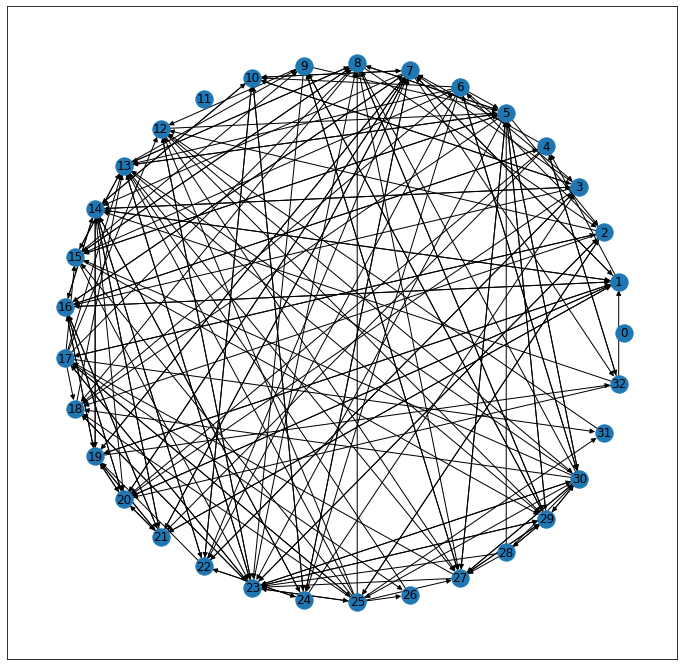

In [17]:
g = get_links(pcmci, pcmci_res, alpha_level = 0.001)
plt.figure(figsize=[12, 12])
nx.draw_networkx(g, pos=nx.circular_layout(g))

### Simple test run
The two following blocks use different Q matrix consstruction methods.

* The first one is the one described in the paper. We implement it with our own understanding of the original algorithm.
* The second one just uses the Pearson correlation coefficient as the correlation algorithm.

In [21]:
tic = time.perf_counter()
Q = get_Q_matrix_part_corr(g, rho=0.2)
vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=15)
gamma = get_gamma(vis_list, eta, lambda_param=0.5)
prks, acc = evaluate(gamma)
toc = time.perf_counter() - tic
print(f"Randwalk time: {toc} seconds")

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.2500  0.5000    0.1500  0.9167
Randwalk time: 9.484521699999732 seconds


In [20]:
tic = time.perf_counter()
Q = get_Q_matrix(g, rho=0.2)
vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=15)
gamma = get_gamma(vis_list, eta, lambda_param=0.5)
prks, acc = evaluate(gamma)
toc = time.perf_counter() - tic
print(f"Randwalk time: {toc} seconds")

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.2500    0.0500  0.9091
Randwalk time: 0.6695444000001771 seconds


## Run Microcause with different parameters
Use the commented code to log results to a Excel spreadsheet. 
We search for possible parameters and then average the results as the final results.

In [17]:
# workbook_name = 'ComparisonExpLog.xlsx'
# sheet_name = 'Comparison Experiments(Real)'
# from openpyxl import load_workbook
# wb = load_workbook(workbook_name)
# sheet = wb[sheet_name]
# row = 13
# column_base = 72

for rho in np.arange(0.0, 1.2, 0.2):
    for walk_step in [15, 25, 35]:
        for lambda_param in np.arange(0.0, 1.2, 0.2):
            Q = get_Q_matrix(g, rho=rho)
            vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=walk_step)
            gamma = get_gamma(vis_list, eta, lambda_param=lambda_param)
            prks, acc = evaluate(gamma)
            
#             sheet.cell(row=row, column=column_base, value=n_init)
#             sheet.cell(row=row, column=column_base+1, value=1e-3)
#             sheet.cell(row=row, column=column_base+2, value=300)
#             sheet.cell(row=row, column=column_base+3, value=0.05)
#             sheet.cell(row=row, column=column_base+4, value=0.001)
#             sheet.cell(row=row, column=column_base+5, value=rho)
#             sheet.cell(row=row, column=column_base+6, value=f"1000,{walk_step}")
#             sheet.cell(row=row, column=column_base+7, value=lambda_param)
#             for i, prk in enumerate(prks):
#                 sheet.cell(row=row, column=column_base+8+i, value=prk)
#             sheet.cell(row=row, column=column_base+13, value=np.mean(prks))
#             sheet.cell(row=row, column=column_base+14, value=acc)
#             row += 1
# wb.save(workbook_name)

  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.3333  0.2500  0.5000    0.3167  0.8788
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.5000  0.3333  0.2500  0.5000    0.3167  0.9091
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.3333  0.2500  0.2500    0.1667  0.9091
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.0000    0.0000  0.8939
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000  0.2500    0.0500  0.9167
  PR@1    PR@2    PR@3    PR@4    PR@5    PR@Avg     Acc
------  ------  ------  ------  ------  --------  ------
0.0000  0.0000  0.0000  0.0000 

KeyboardInterrupt: 

In [ ]:
for rho in np.arange(0.0, 1.2, 0.2):
    Q = get_Q_matrix(g, rho=rho)
    vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=15)
#     print(vis_list)
    l = [0 for _ in range(len(data_head))]
    for n, v in vis_list:
        l[n] = v
    evaluate(l)
    gamma = get_gamma(vis_list, eta, lambda_param=lambda_param)
    evaluate(gamma)

In [ ]:
for lambda_param in np.arange(0.1, 1.1, 0.1):
    gamma = get_gamma(vis_list, eta, lambda_param=lambda_param)
    evaluate(gamma)

In [ ]:
for pc_alpha in [0.01, 0.1, 0.15]:
    
    g = get_links(pcmci, pcmci_res, alpha_level = alpha_level)
    Q = get_Q_matrix(g, rho=0.2)
    
    print(vis_list)
    

## Aggregate delta
Test MicroCause with different aggregate delta parameter. We also log the results to an Excel spreadsheet.

In [ ]:
# aggre_delta = 2
for aggre_delta in range(3, 11):

    data, data_head = load(
        os.path.join("data", data_source, "rawdata.xlsx"),
        normalize=False,
        zero_fill_method=None,
        aggre_delta=aggre_delta,
        verbose=False,
    )

    n_init=int(0.5*len(data))

    tic = time.perf_counter()
    SPOT_res = run_SPOT(data, q=1e-3, d=int(len(data)*0.25), n_init=n_init)
    eta, ab_timepoint = get_eta(SPOT_res, n_init)
    t1 = time.perf_counter() - tic
    tic = time.perf_counter()
    print(f"SPOT time cost: {t1}")

    pcmci, pcmci_res = run_pcmci(pc_alpha = 0.05, verbosity=0)
    g = get_links(pcmci, pcmci_res, alpha_level = 0.001)
    t2 = time.perf_counter() - tic
    tic = time.perf_counter()
    print(f"PCMCI time cost: {t2}")

    Q = get_Q_matrix(g, rho=0.5)
    vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=35)
    gamma = get_gamma(vis_list, eta, lambda_param=0.8)
    prks, acc = evaluate(gamma)
    t3 = time.perf_counter() - tic
    print(f"Randwalk time cost: {t3}")
    print(f"Total time: {t1+t2+t3}")

    workbook_name = 'ComparisonExpLog.xlsx'
    sheet_name = 'MicroCause'
    from openpyxl import load_workbook
    wb = load_workbook(workbook_name)
    sheet = wb[sheet_name]

    column_base = 1

    sheet.cell(row=row, column=column_base, value=aggre_delta)
    sheet.cell(row=row, column=column_base+1, value=f"n_init={n_init},q=1e-3,d={int(len(data)*0.25)}")
    sheet.cell(row=row, column=column_base+2, value=f"alpha=0.05,link_lvl=1e-3")
    sheet.cell(row=row, column=column_base+3, value=f"rho=0.5,epoch=1000,walkstep=35")
    sheet.cell(row=row, column=column_base+4, value=f"lambda=0.8")
    for i, prk in enumerate(prks):
        sheet.cell(row=row, column=column_base+5+i, value=prk)
    sheet.cell(row=row, column=column_base+10, value=np.mean(prks))
    sheet.cell(row=row, column=column_base+11, value=acc)
    sheet.cell(row=row, column=column_base+12, value=t1)
    sheet.cell(row=row, column=column_base+13, value=t2)
    sheet.cell(row=row, column=column_base+14, value=t3)

    row += 1
    wb.save(workbook_name)

In [ ]:
aggre_delta = 10
n_init = 260
    
data, data_head = load(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=False,
    zero_fill_method='prevlatter',
    aggre_delta=aggre_delta,
    verbose=True,
)

SPOT_res = run_SPOT(data, q=1e-3, d=150)
eta, ab_timepoint = get_eta(SPOT_res)

pcmci, pcmci_res = run_pcmci(pc_alpha = 0.05, verbosity=1)
g = get_links(pcmci, pcmci_res, alpha_level = 0.001)
Q = get_Q_matrix(g, rho=0.5)
vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=35)
gamma = get_gamma(vis_list, eta, lambda_param=0.8)
prks, acc = evaluate(gamma)

## Time measure

For data length of 200, PCMCI in MicroCause fails due to a constant array.

In [ ]:
import time

ori_data, data_head = load(
    os.path.join("data", data_source, "rawdata.xlsx"),
    normalize=False,
    zero_fill_method=None,
    aggre_delta=1,
    verbose=True,
)

In [ ]:
center_index = 4753
win_lens = [200, 1200, 2400, 3600, 4800, 7200]
win_len_ind = 0
data = ori_data[max(0, center_index-win_lens[win_len_ind]//2):\
                min(center_index+win_lens[win_len_ind]//2, len(ori_data)), :]
print(f"len(data)={len(data)}")

n_init=int(0.5*len(data))
tic = time.perf_counter()
SPOT_res = run_SPOT(data, q=1e-3, d=int(len(data)*0.25), n_init=n_init)
eta, ab_timepoint = get_eta(SPOT_res, n_init)
t1 = time.perf_counter() - tic
tic = time.perf_counter()
print(f"SPOT time cost: {t1}")

pcmci, pcmci_res = run_pcmci(pc_alpha = 0.05, verbosity=0)
g = get_links(pcmci, pcmci_res, alpha_level = 0.001)
t2 = time.perf_counter() - tic
tic = time.perf_counter()
print(f"PCMCI time cost: {t2}")

Q = get_Q_matrix(g, rho=0.5)
vis_list = randomwalk(Q, 1000, frontend[0], teleportation_prob=0, walk_step=35)
gamma = get_gamma(vis_list, eta, lambda_param=0.8)
prks, acc = evaluate(gamma)
t3 = time.perf_counter() - tic
print(f"Randwalk time cost: {t3}")
print(f"Total time: {t1+t2+t3}")

In [ ]:
print(f"SPOT time cost: {t1}\nPCMCI time cost: {t2}\nRandwalk time cost: {t3}\nTotal time: {t1+t2+t3}")

In [ ]:
t2+t3